# Lecture 2a: Kernelization

**Generalized linear models**

Joaquin Vanschoren, Eindhoven University of Technology

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

### Feature Maps
* Remember linear models?

$$\hat{y} = \mathbf{w}\mathbf{x} = \sum_{i=0}^{p} w_i \cdot x_i = w_0 \cdot x_0 + w_1 \cdot x_1 + ... + w_p \cdot x_p $$  

* When we cannot fit the data well with linear models, we can learn more complex models by simply adding more dimensions
* Feature map (or _basis expansion_) $\phi$: $ X \rightarrow \mathbb{R}^d $

$$y=\textbf{w}^T\textbf{x} \rightarrow  y=\textbf{w}^T\phi(\textbf{x})$$  

* You still may need MANY dimensions to fit the data
    * Memory and computational cost
    * More likely overfitting


Example: Ridge regression

Coefficients: [0.418]


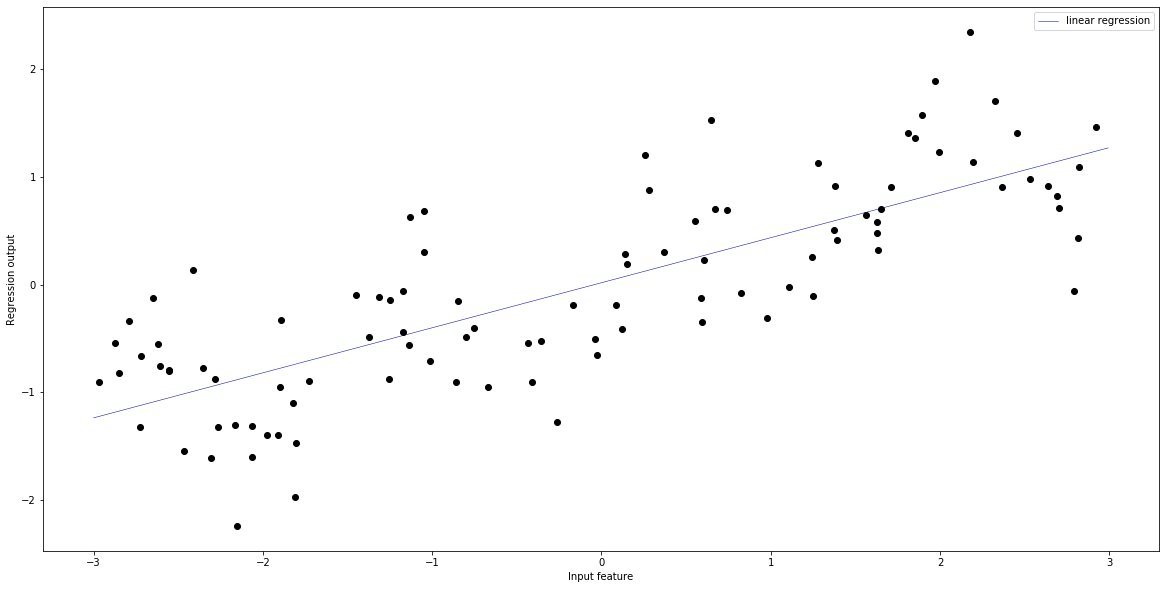

In [2]:
from sklearn.linear_model import Ridge

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = Ridge().fit(X, y)
print("Coefficients:",reg.coef_)
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

* Add all polynomials $x^d$ up to degree D. How large should D be?
* We can also compute all polynomials and all interactions between features (e.g. $x \cdot x^2$). This leads to D^2 features.

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)
styles = [dict(selector="td", props=[("font-size", "150%")]),dict(selector="th", props=[("font-size", "150%")])]
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head().style.set_table_styles(styles)

,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,x0^10
0,-0.75,0.57,-0.43,0.32,-0.24,0.18,-0.14,0.1,-0.078,0.058
1,2.7,7.3,20,53,1.4e+02,3.9e+02,1.1e+03,2.9e+03,7.7e+03,2.1e+04
2,1.4,1.9,2.7,3.8,5.2,7.3,10,14,20,27
3,0.59,0.35,0.21,0.12,0.073,0.043,0.025,0.015,0.0089,0.0053
4,-2.1,4.3,-8.8,18,-37,77,-1.6e+02,3.3e+02,-6.8e+02,1.4e+03


Fit Ridge again:

Coefficients: [ 0.643  0.297 -0.69  -0.264  0.41   0.096 -0.076 -0.014  0.004  0.001]


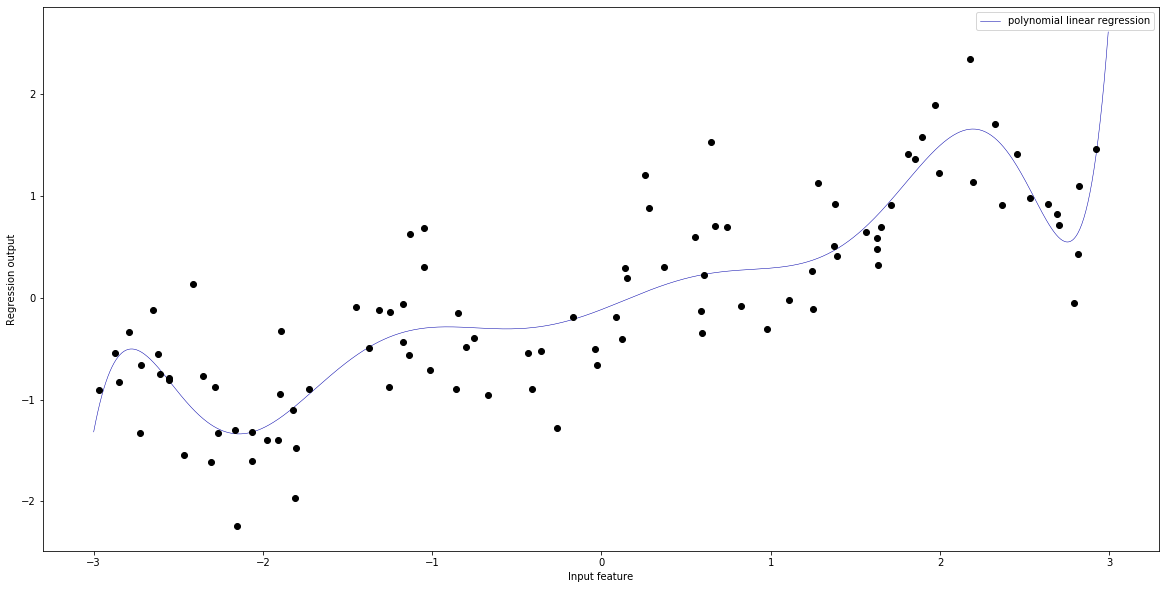

In [4]:
reg = Ridge().fit(X_poly, y)
print("Coefficients:",reg.coef_)
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### How expensive is this?

* Ridge has a closed-form solution which we can compute with linear algebra:
$$w^{*} = (X^{T}X + \lambda I)^{-1} X^T Y$$
* Since X has $n$ rows (examples), and $d$ columns (features), $X^{T}X$ has dimensionality $d x d$
* Hence Ridge is quadratic in the number of features, $\mathcal{O}(d^2n)$
* After the feature map $\Phi$, we get
$$w^{*} = (\Phi(X)^{T}\Phi(X) + \lambda I)^{-1} \Phi(X)^T Y$$
* Since $\Phi$ increases $d$ a _lot_, $\Phi(X)^{T}\Phi(X)$ becomes _huge_
* To be continued...


### Linear models for Classification (recap)
Aims to find a (hyper)plane that separates the examples of each class.  
For binary classification (2 classes), we aim to fit the following function: 

$\hat{y} = w_0 * x_0 + w_1 * x_1 + ... + w_p * x_p + b > 0$  
    
When $\hat{y}<0$, predict class -1, otherwise predict class +1

Again, we can add dimensions when our linear model doesn't fit the data well

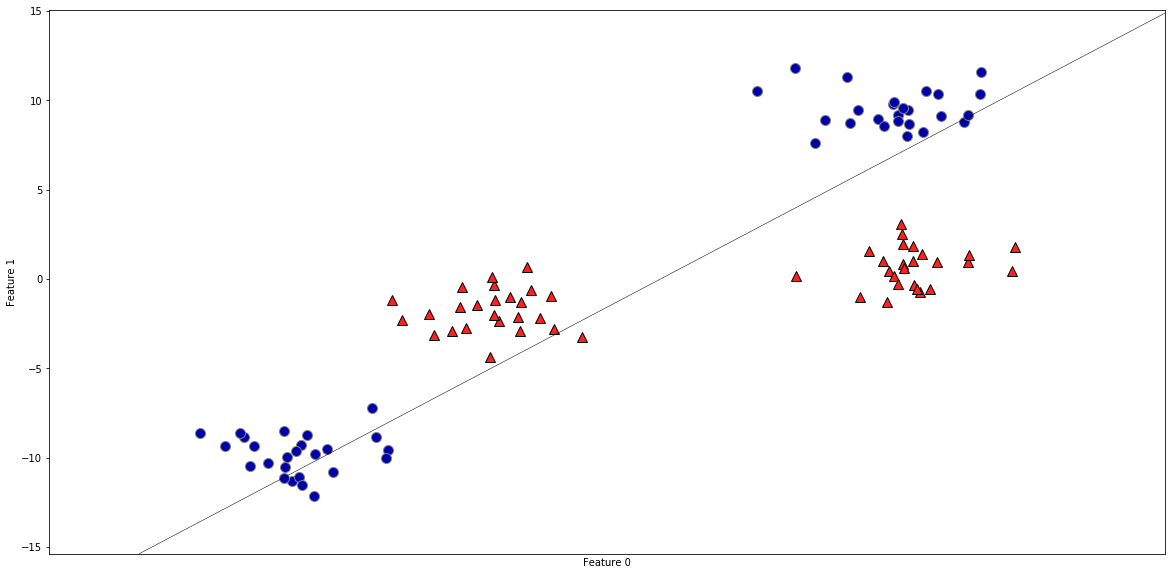

In [5]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import LinearSVC
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

We can add a new feature by taking the squares of feature1 values

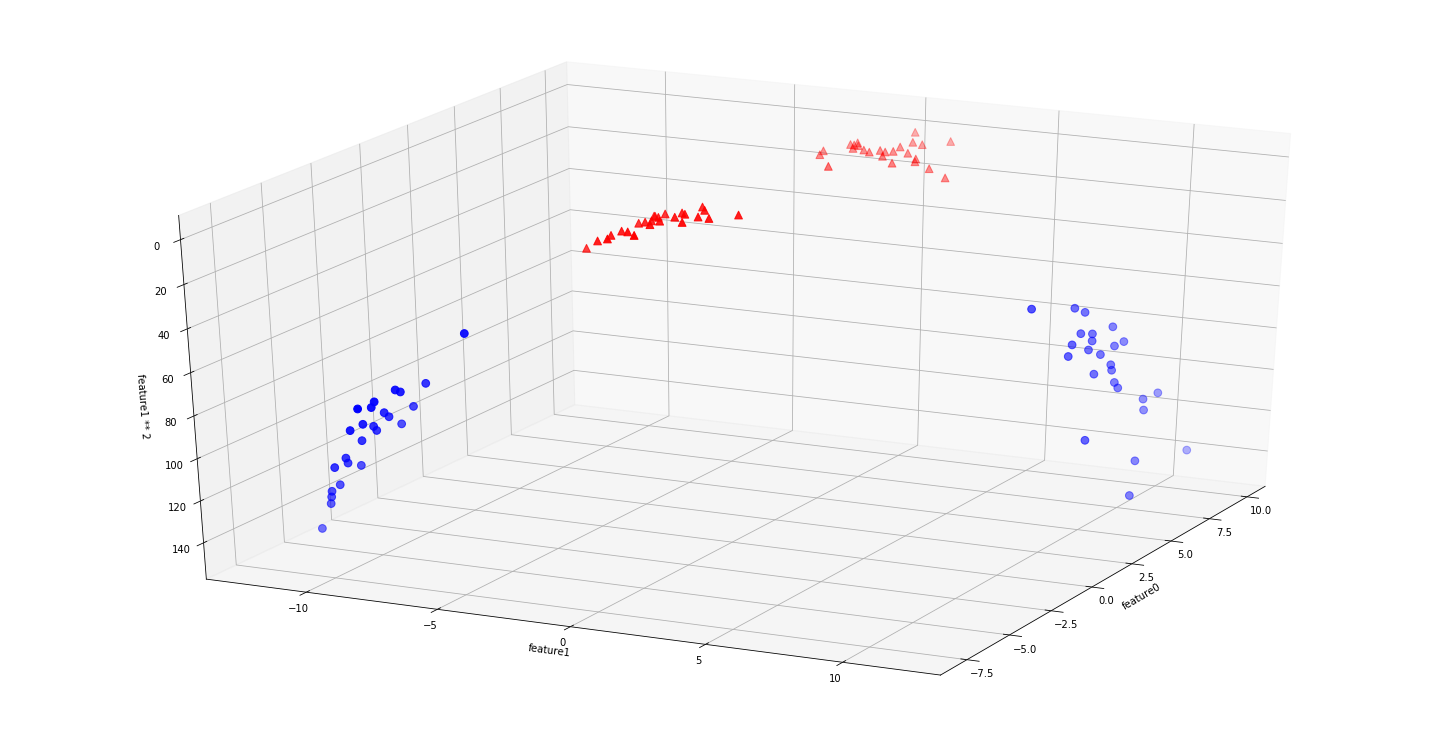

In [6]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])


from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y==0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2");

Now we can fit a linear model

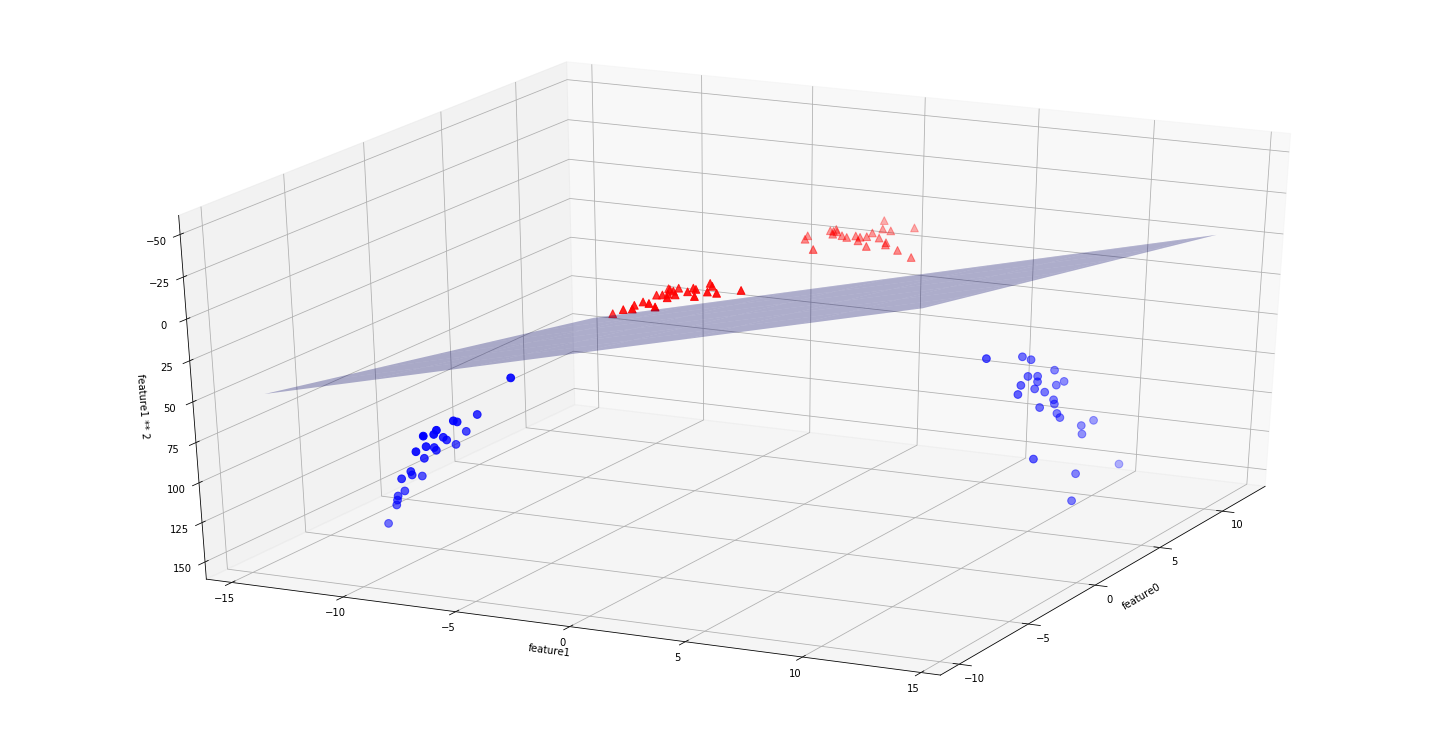

In [7]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60)

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2");

As a function of the original features, the linear SVM model is not actually linear anymore, but more of an ellipse

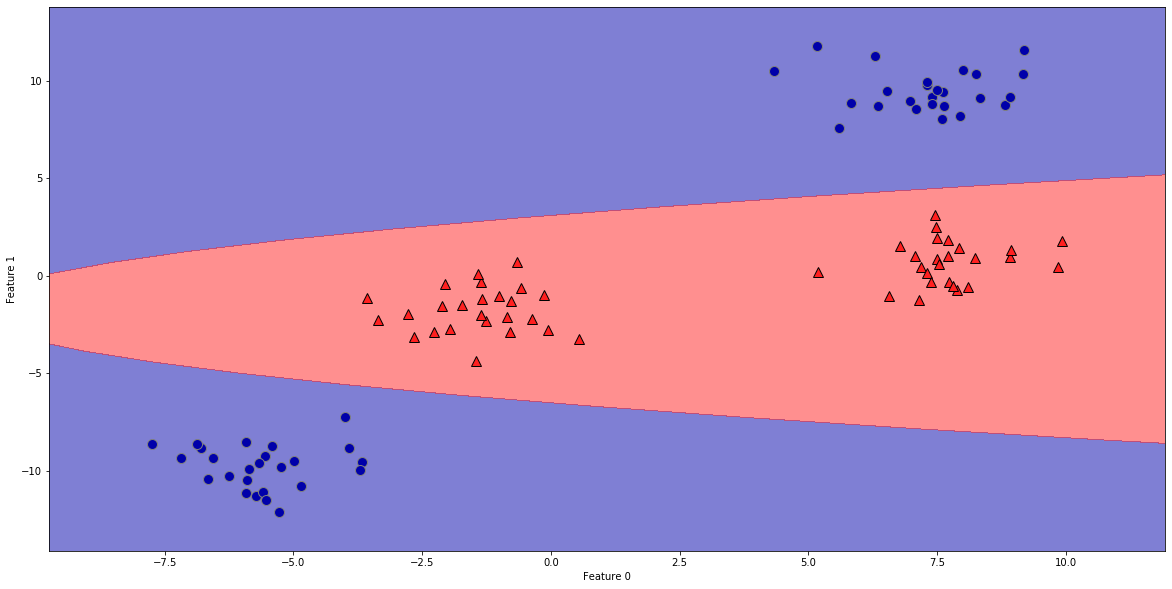

In [8]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1"); 

### Support vector machines (recap)

- In several other linear models, we minimized (misclassification) error
- In SVMs, the optimization objective is to maximize the _margin_
- The __margin__ is the distance between the separating hyperplane and the _support vectors_
- The __support vectors__ are the training samples closest to the hyperplane
- Intuition: large margins generalize better, small margins may be prone to overfitting

<img src="../images/05_margin.png" alt="ml" style="width: 750px;"/>

#### Geometric interpretation (for linearly separable data)
- Imagine a hyperplane defined by coefficients $w$ (and bias $b$)
- We want it to have value 1 in the nearest positive example and value -1 in the nearest negative example
- The hyperplane with the largest margin maximizes $f = \frac{2}{||w||^2}$
    - The factor 2 is for scaling
- And we want that the hyperplane is $> 1$ for all positive examples:  
$g(\mathbf{w}) = y^{(i)} (b +  \mathbf{w^{T}x^{(i)}}) > 1 \,\,\, \forall{i}$
- Find the point ($w_1$, $w_2$) that satifies $g$ but maximizes $f$

<img src="../images/05_lagrangian_multipliers2.png" alt="ml" style="width: 300px;"/>

##### Loss function 

A quadratic loss function with linear constraints can be solved using the *Lagrangian multipliers* methods, which has two solutions. The **Primal** objective is:

$$\mathcal{L}_{Primal} = \frac{1}{2} ||\mathbf{w}||^2 - \sum_{i=1}^{n} a_i y_i (\mathbf{x_i} * \mathbf{w} + b) + \sum_{i=1}^{n} a_i $$

so that

$$ a_i \geq 0 $$ 
$$ \mathbf{w} = \sum_{i=1}^{n} a_i y_i \mathbf{x_i} $$
$$ \sum_{i=1}^{n} a_i y_i = 0 $$

with $n$ the number of training examples and $a$ the _dual variables_, which act like weights for each training example. We find the optimal set of $a$'s first, then the $w$'s can be easily computed. 

Hence, instead of learning the weights, we learn which
examples are important and the model follows from that.

It has a Dual formulation as well (See 'Elements of Statistical Learning'):

$$\mathcal{L}_{Dual} (a_i) = \sum_{i=1}^{l} a_i - \frac{1}{2} \sum_{i,j=1}^{l} a_i a_j y_i y_j (\mathbf{x_i} . \mathbf{x_j}) $$

so that

$$ a_i \geq 0 $$  
$$ \sum_{i=1}^{l} a_i y_i = 0 $$

* Observe the term $\mathbf{x_i} . \mathbf{x_j}$. When the inputs only appear in inner products, we call the method _kernelized_

### Making predictions

- $a_i$ will be *0* if the point lies outside the margin, on the right side of the decision boundary
- The training samples for which $a_i$ is not 0 are the _support vectors_ 
- Hence, the SVM model is completely defined by the support vectors and their coefficients

- Knowing the dual coefficients $a_i$ (of which $l$ are non-zero) we can find the weights $w$ for the maximal margin separating hyperplane:  
$$ \mathbf{w} = \sum_{i=1}^{l} a_i y_i \mathbf{x_i} $$
- Hence, we can classify a new sample $\mathbf{u}$ by looking at the sign of $\mathbf{w}*\mathbf{u}+b$


### SVMs and kNN
Remember, we will classify a new sample *u* by looking at the sign of:  
$f(x) = \mathbf{w}*\mathbf{u}+b$ = $\sum_{i=1}^{l} a_i y_i \mathbf{x_i}*\mathbf{u}+b$

_Weighted k-nearest neighbor_ is a generalization of the k-nearest neighbor classifier. It classifies points by looking at the sign of:  
$f(x) = \sum_{i=1}^{k} a_i y_i dist(x_i, u)$

Hence: SVM's predict exactly the same way as k-NN, only:
- They only consider the truly important points (the support vectors)
    - Thus _much_ faster
- The number of neighbors is the number of support vectors
- The distance function is an _inner product of the inputs_

### SVMs in scikit-learn

- We can use the `svm.SVC` classifier
    - or `svm.SVR` for regression
    - it only support the dual loss function
- To build a linear SVM use `kernel=linear`
- It returns the following:
    - `support_vectors_`: the support vectors
    - `dual_coef_`: the dual coefficients $a$, i.e. the `weigths` of the support vectors
    - `coef_`: only for linear SVMs, the feature weights $w$

``` python
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
print("Support vectors:", clf.support_vectors_[:])
print("Coefficients:", clf.dual_coef_[:])
```

In [9]:
from sklearn import svm

# Linearly separable dat
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# Fit the model
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)

# Get the support vectors and weights
print("Support vectors:")
print(clf.support_vectors_[:])
print("Coefficients:")
print(clf.dual_coef_[:])

Support vectors:
[[-1.021  0.241]
 [-0.467 -0.531]
 [ 0.951  0.58 ]]
Coefficients:
[[-0.048 -0.569  0.617]]


SVM result. The circled samples are support vectors, together with their coefficients.

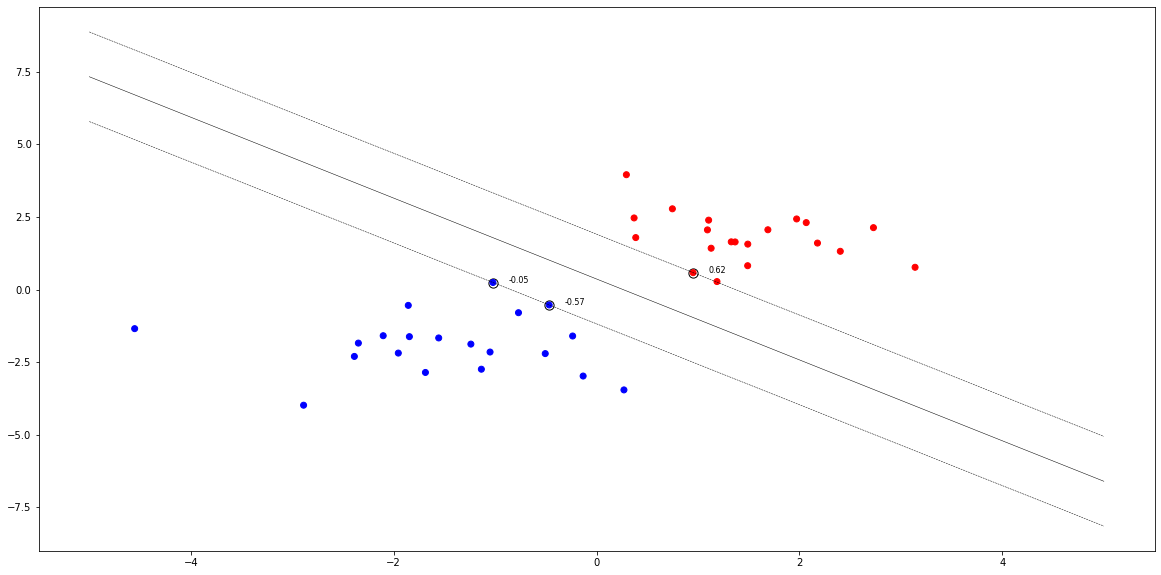

In [10]:
mglearn.plots.plot_svm_linear()

### Dealing with nonlinearly separable data

- If the data is not linearly separable, (hard) margin maximization becomes meaningless
    - The constraints would contradict
- We can allow for violatings of the margin constraint by introducing a _slack variable_ $\xi^{(i)}$ for every data point

$b +  \mathbf{w^{T}x^{(i)}} \geq 1 - \xi^{(i)}  \,\,\, if \,\,\, y^{(i)} = 1$  
$b +  \mathbf{w^{T}x^{(i)}} \leq -1 + \xi^{(i)} \,\,\, if \,\,\, y^{(i)} = -1$  

The new objective (to be minimized) becomes:

$\frac{||w||^2}{2} + C (\sum_i \xi^{(i)})$

- $C$ is a penalty for misclassification
    - Large C: large error penalties
    - Small C: less strict about violations (more regularization)

- This is known as the _soft margin_ SVM (or _large margin_ SVM)
    - Some support vectors are exactly on the margin hyperplane, with margin = 1
    - Others are margin violators, with margin < 1 and a positive slack variable: $\xi^{(i)} > 0$
        - If $\xi^{(i)} \geq 1$, they are misclassified

### C and regularization

- Hence, we can use C to control the size of the margin and overfitting:
    - Small C: Increases bias, reduces variance, more underfitting
    - Large C: Reduces bias, increases variance, more overfitting
- The penalty term $C (\sum_i \xi^{(i)})$ acts as an L1 regularizer on the dual coefficients
    - Also known as hinge loss
    - This induces sparsity: large C values will set many dual coefficients to 0, hence fewer support vectors
    - Small C values will typically lead to more support vectors (more points fall within the margin)
    - Again, it depends on the data how flexible or strict you need to be
-  The _least squares SVM_ is a variant that does L2 regularization
    - Will have many more support vectors (with low weights)
    - In scikit-learn, this is only available for the `LinearSVC` classifier (`loss='squared_hinge'`)

Effect on linearly separable data

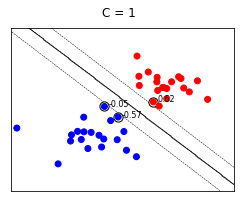

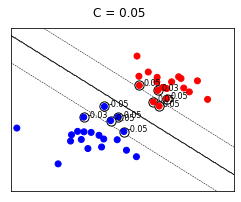

In [11]:
mglearn.plots.plot_svm_margins()

Effect on non-linearly separable data

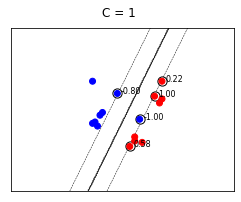

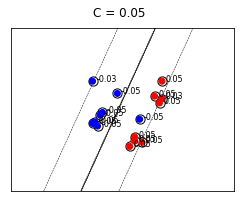

In [12]:
mglearn.plots.plot_svm_margins_nonlin()

#### Other loss functions

It is possible to _generalize_ SVMs by training them with other loss functions and gradient descent as the optimizer

See the `SGDCLassifier` (`SGDCLassifier(loss='hinge')` will act like an SVM)

<img src="../images/05_loss.png" alt="ml" style="width: 400px;"/>

# Kernelization
* A method is _kernelized_ if inputs only appear inside inner products $x_i \cdot x_j$ = $\langle x_i , x_j \rangle$
* We said that SVMs can be _kernelized_ through it's dual formulation:

$$\mathcal{L}_{Dual} (a_i) = \sum_{i=1}^{l} a_i - \frac{1}{2} \sum_{i,j=1}^{l} a_i a_j y_i y_j (\mathbf{x_i} . \mathbf{x_j}) $$

* A _kernel function_ corresponding to a transformation $\Phi$ is

$$ k(x_i,x_j) = \langle \Phi(x_i) , \Phi(x_j) \rangle $$

* $\Phi(x)$ can be used to generate many more features based on the original feature $x$
* Turns out, we can often evaluate $k(x_i,x_j)$ directly, _without_ evaluating $\Phi(x_i) , \Phi(x_j)$

## Kernel trick
* Evaluating the kernel directly can be _much_ cheaper. 
* Example: a simple _quadratic_ feature map for $x = (x1,..., xd )$ has dimension $\mathcal{O}(d^2)$:

$$ \Phi(x) = (x_1,..., x_d , x_1^2,..., x_d^2 , \sqrt{2} x_1 x_2 , ..., \sqrt{2} x_{d-1} x_{d}) $$

* The corresponding quadratic kernel is:

$$ k(x_i,x_j) = \langle \Phi(x_i) , \Phi(x_j) \rangle = \langle x_i , x_j \rangle + \langle x_i , x_j \rangle^2$$

* We can skip the computation of $\Phi(x_i)$ and $\Phi(x_j)$ and compute $k(x_i,x_j)$ in $\mathcal{O}(d)$ instead of $\mathcal{O}(d^2)$!

## Kernel functions
* It is useful to think of a kernel as a similarity score between 2 vectors (points)
    * Not mathematically equivalent
* There are many ways to design such a similarity score (also for text, graphs,...)
* Computationally _much_ cheaper
* We can access very large (even infinite) feature spaces $\mathcal{H}$
* Thinking in terms of similarity is much more intuitive than thinking in high-dimensional feature spaces

### Linear kernel
* Input space is same as output space: $X = \mathcal{H} = \mathbb{R}^d$
* Feature map $\Phi(x) = x$
* Kernel: $ k(x_i,x_j) = x_i \cdot x_j = x_i^T x_j $
* Geometrically, we can view these as _projections_ of $x_j$ on a hyperplane defined by $x_i$
    * Nearby points will have nearby projections
    
<img src="../images/05_dotproduct.png" alt="ml" style="width: 200px;"/>

## Kernel matrix
For points of $x_1,..., x_n \in X$ and an inner product $\langle \cdot , \cdot \rangle$, the kernel 
matrix (or Gram matrix) is defined as:

$$ K =  \begin{bmatrix}
                    \langle x_1 , x_1 \rangle & \ldots & \langle x_1 , x_n \rangle \\
                    \vdots & \ddots & \vdots \\
                    \langle x_n , x_1 \rangle & \ldots & \langle x_n , x_n \rangle
                  \end{bmatrix} \\[15pt]$$
                  
* For the Euclidean inner product $ k(x_i,x_j) = x_i^T x_j $, we have $K=XX^T$
* Size is $n x n$, irrespective of number of dimensions $d$
* Once kernel matrix is computed, cost depends on number of data points only


### Kernels

More generally, a (Mercer) kernel on a space X is a function  

$k: X \times X \rightarrow \mathbb{R}$

With the properties: 

- Symmetry: $k(x_1,x_2) = k(x_2,x_1) \,\,\, \forall x_1,x_2 \in X$
- Positive definite: for each finite subset of data points ${x_1,...,x_n}$, the kernel Gram matrix is positive semi-definite
    - Intuitively, $k(x_1,x_2) \geq 0$

This is also what we expect from similarity functions

#### Kernels: examples

- The inner product is a kernel. The standard inner product is the __linear kernel__:  
$k(x_1,x_2) = x_1^T x_2$

- Kernels can be constructed from other kernels $k_1$ and $k_2$:
    - For $\lambda \geq 0, \lambda . k_1$ is a kernel
    - $k_1 + k_2$ is a kernel
    - $k_1 . k_2$ is a kernel (thus also $k_1^n$)
- This allows to construct the __polynomial kernel__:  
$k(x_1,x_2) = (x_1^T x_2 + b)^d$, for $b \geq 0$ and $d \in \mathbb{N}$ 

- The 'radial base function' (or __Gaussian__) kernel is defined as:  
$k(x_1,x_2) = exp(-\gamma ||x_1 - x_2||^2)$, for $\gamma \geq 0$ 

![gamma](../images/05_gaussian_curves.png)

#### The Kernel Trick (summary)

* Explictly adding nonlinear features can make linear models much more powerful, but also much more expensive
* Given a kernelized ML algorithm, we can swap out the inner product for a new kernel function.
* Kernel functions allow us to directly compute distances (scalar products) in an implicit high dimensional space (you don't actually construct it)
* A _kernel function_ is a distance (similarity) function with special properties for which this trick is possible
    * Polynomial kernel: computes all polynomials up to a certain degree of the original features
    * Gaussian kernel, or radial basis function (RBF): considers all possible polynomials of all degrees
        * Infinite high dimensional space (Hilbert space), where the importance of the features decreases for higher degrees

### Gaussian kernel: intuition
- Each point generates a function, the inner product is where they intersect
- The closer the points are, the more similar they are

<img src="../images/05_kernel_map.png" alt="ml" style="width: 400px;"/>

Example (for regression):
* We have 6 input points: [-6,-4,-3,0,2,4]
    * We fit a kernel over each (blue)
* We learn a coefficient for each: e.g. [-.8,.5,-0.5,.7,0.3,-0.2]
* Resulting preditions (red curve)
* Linear kernels will produce a linear function, Gaussian kernels can produce very complex functions.

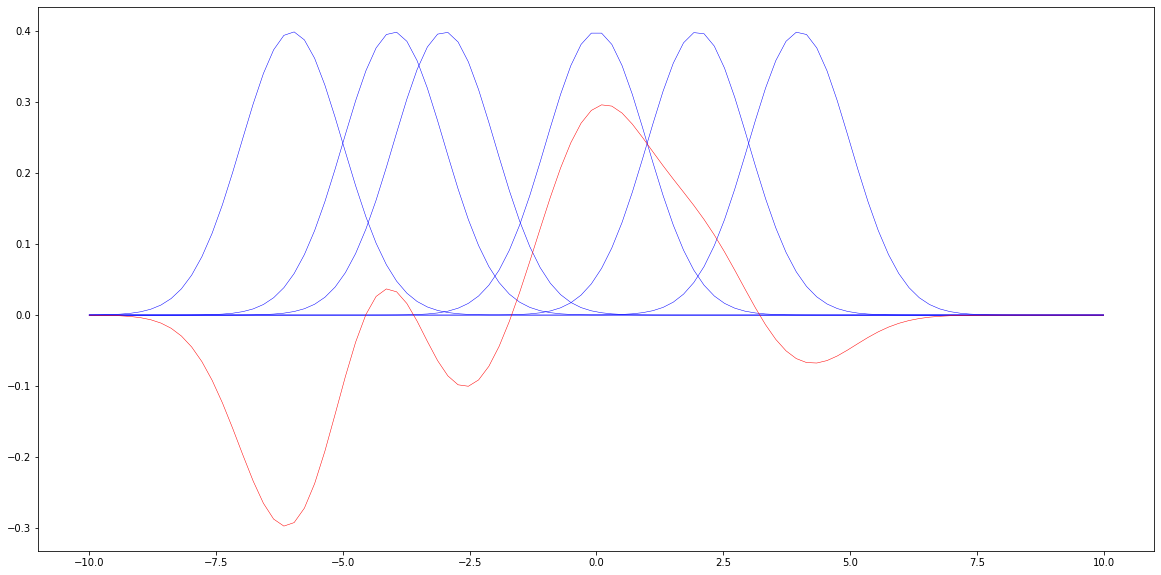

In [13]:
import scipy.stats as stats
import math

xs = [-6,-4,-3,0,2,4]
alphas = [-.8,.5,-0.5,.7,0.3,-0.2]
variance = 1
sigma = math.sqrt(variance)
p = np.linspace(-10, 10, 100)
f = [0]*100
for a,x in zip(alphas,xs):
    k = stats.norm.pdf(p, x, sigma)
    f += a*k
    plt.plot(p, k, 'b-')
plt.plot(p, f, 'r-')
plt.plot()
plt.show()

Example (for classification):
* In the RBF SVM, every support vector generates a 2D Gaussian, the final prediction is the sum of those
* At prediction time, you evaluate each Gaussian (a kind of distance between the new point and the support vector) and sum up the values

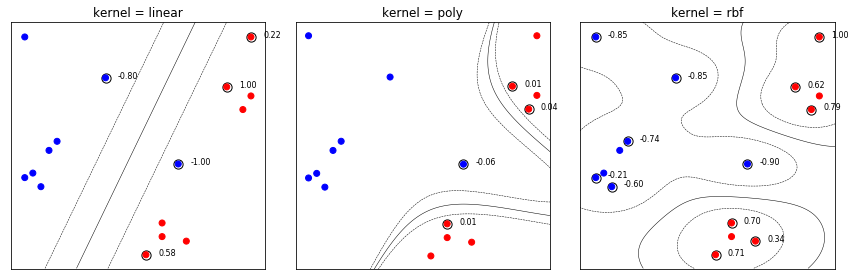

In [14]:
mglearn.plots.plot_svm_kernels()

### Local vs Global kernels
* With a linear or polynomial kernel, one support vector can affect the whole model space
    - These are called _global kernels_
* The RBF kernel only affects the region around the support vector (depending on how wide it is)
    - This a called a _local_ kernel
    - Can capture local abnormalities that a global kernel can't
    - Also overfits easily if the kernels are very narrow 

### Tuning SVM parameters
Several important parameters:

* gamma ((inverse) kernel width): high values means that points are further apart
    * High values mean narrow Gaussians, i.e. the influence of one point is very small
        * You need many support vectors
    * Leads to complex decision boundaries, overfitting
* C (our linear regularizer): 'cost' of misclassifying training examples
    * High C: force SVM to classify more examples correctly 
        * Requires more support vectors, thus complex decision boundaries
* For polynomial kernels, the _degree_ (exponent) defines the complexity of the models

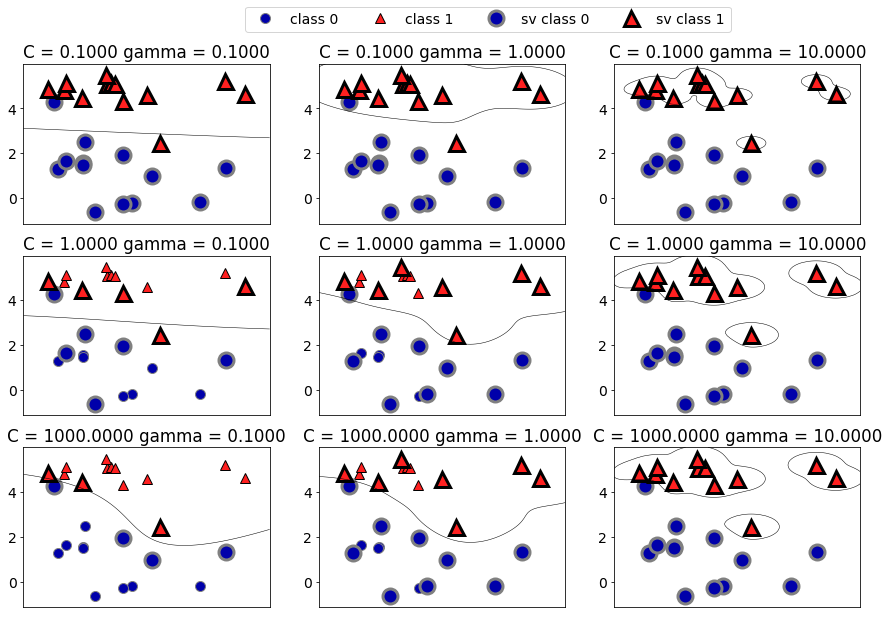

In [15]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2));

* Low gamma (left): wide Gaussians, very smooth decision boundaries
* High gamma (right): narrow Gaussians, boundaries focus on single points (high complexity)
* Low C (top): each support vector has very limited influence: many support vectores, almost linear decision boundary
* High C (bottom): Stronger influence, decision boundary bends to every support vector

Kernel overview

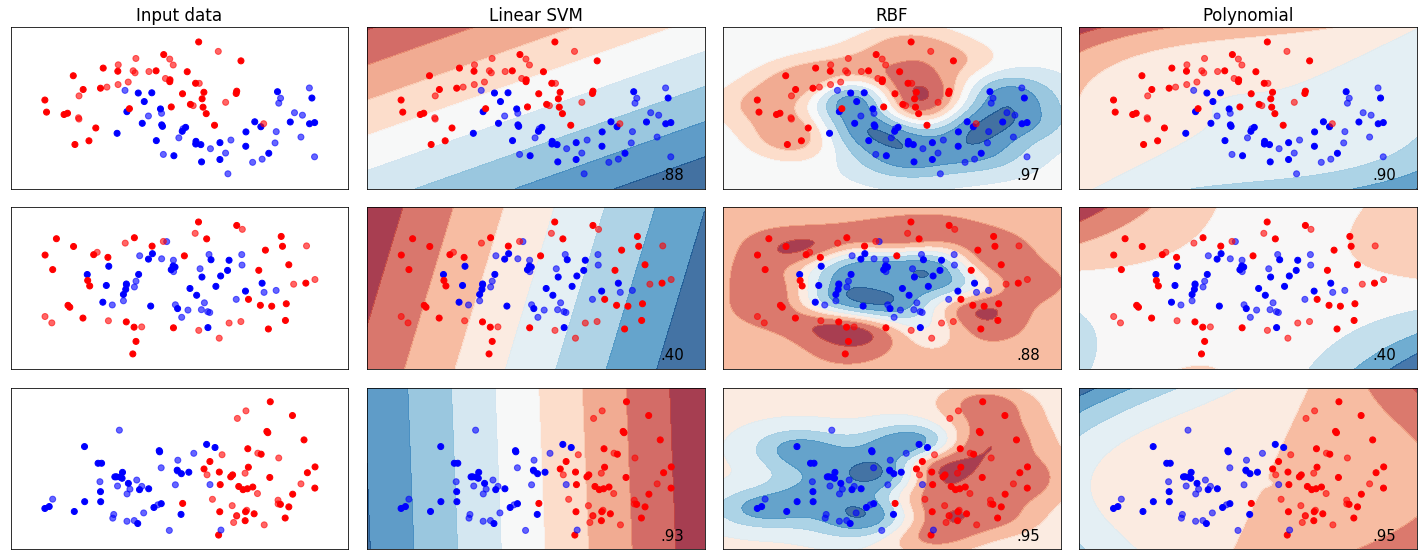

In [18]:
from mglearn import plot_classifiers
from sklearn.svm import SVC
names = ["Linear SVM", "RBF", "Polynomial"]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(kernel="poly", degree=3, C=0.1)
    ]
 
plot_classifiers.plot_classifiers(names, classifiers, figuresize=(20,8)) 

### Preprocessing Data for SVMs
* SVMs are very sensitive to hyperparameter settings
* They expect all features to be approximately on the same scale
* Data point similarity (e.g. RBF kernel) is computed the same way in all dimensions
* If some dimension is scaled differently, it will have a much larger/smaller impact
* We'll get back to this in Lecture 4 (pipelines).

### Strengths, weaknesses and parameters

* SVMs allow complex decision boundaries, even with few features. 
* Work well on both low- and high-dimensional data

* Don't scale very well to large datasets (>100000)
* Require careful preprocessing of the data and tuning of the parameters. 
* SVM models are hard to inspect

Important parameters:
* regularization parameter _C_
* choice of the kernel and kernel-specific parameters
    * Typically string correlation with _C_

## Generalized linear models
We can generalize the SVM objective as follows:
$$\mathcal{J}(w) = \mathcal{R} (||w||)+\mathcal{L}(\langle w,\Phi(x_1)\rangle,...,\langle w,\Phi(x_n)\rangle)$$

Where $\mathcal{R}$ is a (non-decreasing) regularization score and $\mathcal{L}$ is an _arbitrary_ loss function
* The _Representer Theorem_ says that if J(w) has a minimizer, it has a minimizer of the form
$$w^{*} = \sum_{i=1}^{n} \alpha_i \Phi(x_i)$$
* This is what we already discovered for SVMs (but with a lot more work)
    

## Generalized linear models
* In the same way, we can define:
    * Kernelized SVMs
    * Kernelized Ridge regression
    * 1-layer neural networks
        * The 'kernel' here is the activation function
* We can also define kernels for text, graphs, and many other types of data